In [1]:
from pyspark import SparkConf, SparkContext

conf = SparkConf().setMaster('local').setAppName('restaurant-review-average')
sc = SparkContext(conf = conf)


filepath = '/home/ubuntu/working/spark-examples/data/restaurant_reviews.csv'
lines = sc.textFile(f'file:///{filepath}') 
lines.collect()

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/06/05 00:24:33 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


['id,item,cateogry,reviews,',
 '0,짜장면,중식,125,',
 '1,짬뽕,중식,235,',
 '2,김밥,분식,32,',
 '3,떡볶이,분식,534,',
 '4,라멘,일식,223,',
 '5,돈가스,일식,52,',
 '6,우동,일식,12,',
 '7,쌀국수,아시안,312,',
 '8,햄버거,패스트푸드,12,',
 '9,치킨,패스트푸드,23']

In [3]:
header = lines.first()
filtered_lines = lines.filter(lambda x: x!=header)
filtered_lines.collect()

['0,짜장면,중식,125,',
 '1,짬뽕,중식,235,',
 '2,김밥,분식,32,',
 '3,떡볶이,분식,534,',
 '4,라멘,일식,223,',
 '5,돈가스,일식,52,',
 '6,우동,일식,12,',
 '7,쌀국수,아시안,312,',
 '8,햄버거,패스트푸드,12,',
 '9,치킨,패스트푸드,23']

In [4]:
def parse(row):
    fields = row.split(',')
    category = fields[2]
    reviews = int(fields[3])
    
    return category, reviews

cache, persist 쓸 때 어떤 문제가 있을까?

1. `persist`를 사용하지 않는 경우

In [7]:
categoryReviews = filtered_lines.map(parse)
categoryReviews.collect()

[('중식', 125),
 ('중식', 235),
 ('분식', 32),
 ('분식', 534),
 ('일식', 223),
 ('일식', 52),
 ('일식', 12),
 ('아시안', 312),
 ('패스트푸드', 12),
 ('패스트푸드', 23)]

In [9]:
result1 = categoryReviews.take(10)
result2 = categoryReviews.mapValues(lambda x : (x,1)).collect()

In [10]:
result1, result2

([('중식', 125),
  ('중식', 235),
  ('분식', 32),
  ('분식', 534),
  ('일식', 223),
  ('일식', 52),
  ('일식', 12),
  ('아시안', 312),
  ('패스트푸드', 12),
  ('패스트푸드', 23)],
 [('중식', (125, 1)),
  ('중식', (235, 1)),
  ('분식', (32, 1)),
  ('분식', (534, 1)),
  ('일식', (223, 1)),
  ('일식', (52, 1)),
  ('일식', (12, 1)),
  ('아시안', (312, 1)),
  ('패스트푸드', (12, 1)),
  ('패스트푸드', (23, 1))])

categoryReviews는 result1, result2를 만들면서 2번 만들어집니다. categoryReviews에서 데이터를 꺼내오기만 하면되지 변경은 일어나지 않기 떄문에 persist를 이용해서 categoryReview를 메모리에 넣어 놓는 것이 더 좋아 보입니ㅏㄷ.

현재 데이터 구조
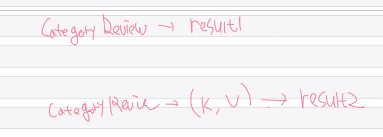

이런 구조로 deg이 그려진다면 cache, persist 가 유리할 수도.

2. `persist`를 사용하는 경우

In [13]:
# persist = 디스크에 기록되지 않는 RDD 만들기
# 결과물이 디스크에 기록되지 않고 메모리에만 기록이 됨
# categoryReviews RDD는 메모리에 상주하는 RDD
# 메모리 -> 디스크 -> 메모리 -> 디스크
categoryReviews = filtered_lines.map(parse).persist()
categoryReviews.collect()


[('중식', 125),
 ('중식', 235),
 ('분식', 32),
 ('분식', 534),
 ('일식', 223),
 ('일식', 52),
 ('일식', 12),
 ('아시안', 312),
 ('패스트푸드', 12),
 ('패스트푸드', 23)]

In [14]:
result1 = categoryReviews.take(10)
result2 = categoryReviews.mapValues(lambda x:(x,1)).collect()

In [15]:
sc.stop()

결론: 하나의 RDD를 기반으로 여러 연산(Transformations, Action 모두) 일어날 때는 persist()를 사용하면 좋다!
- 대표적으로 머신러닝 훈련 데이터